In [6]:
import shelve

import matplotlib.pyplot as plt
import pandas as pd

In [7]:
# User parameters
out_base = "GRCh38-no_ambig.p14"
analysis_checkpoint_file_path = f"{out_base}-analysis-checkpoints.db"

# Run analysis

Since generating statistics can be time-consuming, these steps have been consolidated into two separate scripts that can be run outside of this notebook.  If the analysis has not yet been run, the following steps are required.

1. Download the human genome and decompress it.

```bash
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_genomic.fna.gz
gzip -d GCF_000001405.40_GRCh38.p14_genomic.fna.gz
```

2. Build the $k$-mers for the human genome and sort them lexicographically.

```bash
python3 ./build_kmers.py -i GCF_000001405.40_GRCh38.p14_genomic.fna -o GRCh38.p14-kmers.hdf5
```

*Approximate run time: 2 hours*

3. Load the sorted $k$-mers and calculate the $k$-mer count distribution for a range of $k$ values.

```bash
python3 ./get_kmer_stats.py -i GRCh38.p14-kmers.hdf5 -o GRCh38.p14-analysis-checkpoints.db
```

*Approximate run time: 20 hours*

## Load analysis results from file

In [8]:
with shelve.open(analysis_checkpoint_file_path) as db:
    kmer_len_list = db["kmer_len_list"]
    
    group_hist_list = db["group_hist_list"]
    total_kmers_list = db["total_kmers_list"]
    run_times_all_list = db["run_times_all_list"]

    group_hist_unique_list = db["group_hist_unique_list"]
    total_kmers_unique_list = db["total_kmers_unique_list"]
    run_times_unique_list = db["run_times_unique_list"]

## Plot unique $k$-mers

Start by building a dataframe with the information we need

In [9]:
# Get the number unique k-mers for each value of k
unique_kmer_counts = []
for group_counts_by_group_size in group_hist_unique_list:
    # verify that the only group size is 1 for group_hist_unique_list.  This means that
    # group_count == kmer_count
    assert group_counts_by_group_size[1] == group_counts_by_group_size.sum()
    unique_kmer_counts.append(group_counts_by_group_size[1])

# build dataframe
data = []
generator = zip(kmer_len_list, unique_kmer_counts, total_kmers_list)
for kmer_len, unique_kmer_count, total_kmer_count in generator:
    data.append([kmer_len, unique_kmer_count, total_kmer_count])
df = pd.DataFrame(data, columns=["kmer_len", "unique_kmer_count", "total_kmer_count"])

# add a column with the fraction of unique k-mers
df["frac_unique"] = df["unique_kmer_count"] / df["total_kmer_count"]

display(df.head())
display(df.tail())

,kmer_len,unique_kmer_count,total_kmer_count,frac_unique
0,1,0,2937639113,0.0
1,2,0,2937638136,0.0
2,3,0,2937637172,0.0
3,4,0,2937636211,0.0
4,5,0,2937635259,0.0


,kmer_len,unique_kmer_count,total_kmer_count,frac_unique
48,300,2870403389,2937378904,0.977199
49,350,2876055677,2937337194,0.979137
50,400,2880832457,2937296056,0.980777
51,450,2884916721,2937255120,0.982181
52,500,2888441365,2937214270,0.983395


Plot the fraction of all $k$-mers that appear exactly once in the genome as a function of $k$

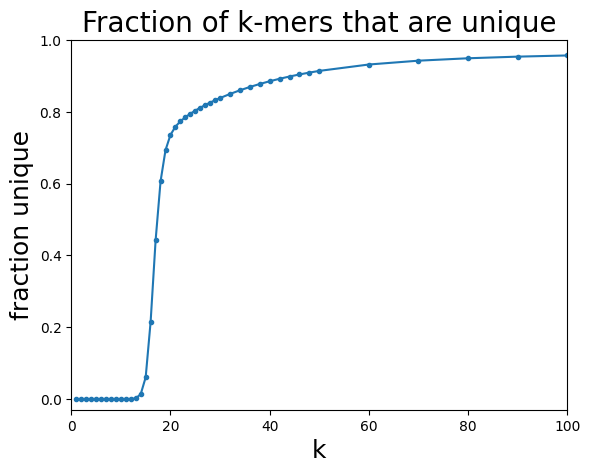

In [10]:
# plot fraction of k-mers that are unique as a function of k
fig, ax = plt.subplots()

ax.plot(df["kmer_len"], df["frac_unique"], "-o", markersize=3)
ax.set_xlim(0, 100)
ax.set_ylim(-0.03, 1.0)
ax.set_title("Fraction of k-mers that are unique", fontsize=20)
ax.set_xlabel("k", fontsize=18)
ax.set_ylabel("fraction unique", fontsize=18)

fig.savefig(f"{out_base}-frac-unique-kmers.png", dpi=300)